# PMLDL Assignment 1

**Content-Based Image Retrieval**


Similar Image Retrieval (aka Content-Based Image Retrieval or CBIR) is any search that involves images.
Nowadays the "Search by photo" approach is being used more and more actively, in particular, in e-commerce services (AliExpress, Wildberries, etc.). "Keyword search" (with an understanding of the content of images) has long settled in the search engines Google, Yandex, etc.,

**How does it work ?**


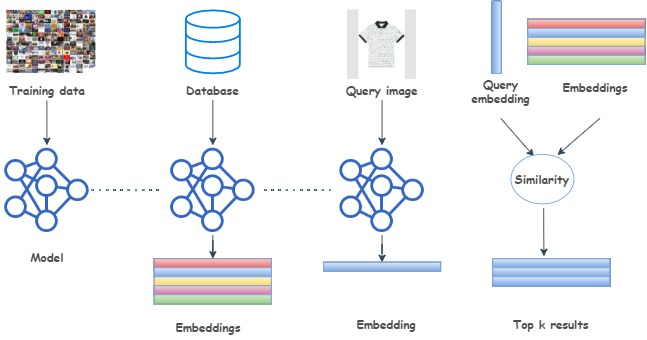


As you can see the pipeline seems easy. First we need a dataset, in this assignment we will be using a large scale benchmark dataset called the Inshop dataset (use the one provided in the link ;) ). The dataset contains training set and testing set. The testing set is divided into two parts query images and gallery images. The query set basically contains images that we will be searching for in the gallery set.



**Steps:**
1. Download the dataset
2. Read the dataset and put it in an appropriate format
3. Choose a model (you can use pretrained ;) ) and train it
4. Wisely choose a loss function in deep metric learning there are many such as : Contrastive loss, Triplet loss, multi similarity loss, XBM .... Implement one of them.
5. Measure the scores using the recall metric
6. Report results ( recall values , loss) using tensorboard or Comet or any tool you are comfortable with.  


**Bonus tasks**



1.   Use of hard negative miner (15 points)
2.   Use of PytorchLightening (10 points)




In [ ]:
import os
import torch
import time
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from pytorch_metric_learning import losses

## Read data

In [ ]:
transform = transforms.Compose([transforms.CenterCrop(200),
                                transforms.ToTensor()])

train_set = datasets.ImageFolder('Inshop-data/train_data', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)

gallery_set = datasets.ImageFolder('Inshop-data/gallery_data/gallery', transform=transform)
gallery_loader = torch.utils.data.DataLoader(gallery_set, batch_size=32, shuffle=False)

query_set = datasets.ImageFolder('Inshop-data/query_data/query', transform=transform)
query_loader = torch.utils.data.DataLoader(query_set, batch_size=32, shuffle=False)

## Model

In [ ]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.pool = nn.MaxPool2d(3, 3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 10)
        self.fc1 = nn.Linear(12*18*18, 3997)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 12*18*18)
        x = self.fc1(x)
        return x

    # to obtain embeddings
    def forward2(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

In [ ]:
model = Model()
criterion = losses.ContrastiveLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train

In [ ]:
def train(loader, epochs=2):
    for epoch in range(epochs):
        for i, data in enumerate(loader, 0):
            images, labels = data
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                print(epoch + 1, i + 1)

In [ ]:
train(train_loader)

C:\Anaconda\envs\IR environment\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1 100
1 200
1 300
1 400
1 500
1 600
1 700
1 800
2 100
2 200
2 300
2 400
2 500
2 600
2 700
2 800


In [ ]:
train(gallery_loader)

1 100
1 200
1 300
2 100
2 200
2 300


## Visualization


Use a retrieval technique like KNN, annoy, KD-tree (you are free to choose).

Plot 3 query images with their respective top 5 results



In [ ]:
gallery_imgs, gallery_feats = [], []
for i, data in enumerate(gallery_loader, 0):
    images, labels = data
    for current_image in images:
        gallery_imgs.append(current_image)
        current_feats = model.forward2(current_image.reshape(1, 3, 200, 200))
        gallery_feats.append(np.array(current_feats.tolist()).flatten())
gallery_feats = np.array(gallery_feats)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 5)
neigh.fit(gallery_feats)

NearestNeighbors()

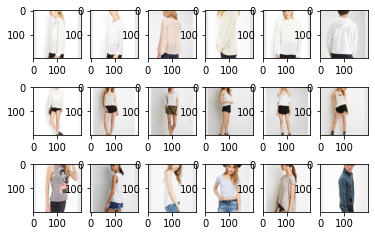

In [ ]:
images, labels = next(iter(query_loader))
for i in range(3):
    current_image = images[i]
    plt.subplot(3, 6, i*6+1).imshow(current_image.permute(1, 2, 0))
    current_feats = model.forward2(current_image.reshape(1, 3, 200, 200))
    current_feats = np.array(current_feats.tolist()).flatten()
    current_neighbours = neigh.kneighbors(current_feats.reshape(1, -1), 5, return_distance=False).tolist()
    for j in range(len(current_neighbours[0])):
        current_neighbour = gallery_imgs[current_neighbours[0][j]].permute(1, 2, 0)
        plt.subplot(3, 6, i*6+j+2).imshow(current_neighbour)

In [ ]:
# ref: https://alexanderkurakin.blogspot.com/2018/12/pytorch-image-classifier.html